In [95]:
import ugradio
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
import scipy.signal
import cmasher
import glob
import barycorrpy
import cmasher as cmr
from matplotlib.ticker import FuncFormatter
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter, LatitudeLocator, LongitudeLocator)
from scipy.signal import medfilt
%matplotlib widget

#### Plot Formatting

In [270]:
# ---------- Plot Formatting ---------
plt.rc('font', family='times new roman', size=14) # you can change fonts, ex. family = 'serif'
plt.rc('xtick', labelsize=12) # you can change tick sizes
plt.rc('ytick', labelsize=12)
# --------- End Formatting ----------

In [3]:
phases = ['/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase1',
          '/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase2',
          '/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/FFC_4-main/data/obs_042524']
noise  = ['/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Noise_Spectra']
files = [file for directory in phases for file in glob.glob(f'{directory}/*.npz')]
noisefiles = [file for directory in noise for file in glob.glob(f'{directory}/*.npz')]


In [4]:
loadcols = ['L', 'B', 'RA', 'DEC', 'Galactic_Index']
df = pd.read_csv('/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/Leusch_Stuff/RA_Sorted.csv',
                  usecols=loadcols)

In [5]:
df

,L,B,RA,DEC,Galactic_Index
0,124.4,20.0,23.851192,82.746098,168
1,124.4,23.4,32.778248,86.042542,169
2,129.0,20.0,52.084066,80.962227,180
3,133.6,20.0,69.006710,77.908980,192
4,129.0,23.4,69.993942,83.367395,181
...,...,...,...,...,...
319,115.2,23.4,309.232324,82.078465,145
320,110.6,20.0,312.501293,76.649154,132
321,115.2,20.0,326.412516,79.953801,144
322,119.8,23.4,334.954938,85.318438,157


#### Pointings for table 1 in paper.

In [6]:
latex_table = df.to_latex(index=False, header=True)
# print(latex_table)    # uncomment to see list of values, copy/paste into paper

In [7]:
leusch_coords = sorted(files, key=lambda x: np.load(x)['coords'][5])

In [8]:
np.sort(files)
print(files[0])

/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase1/spec36_L170_B27.npz


In [9]:
'''
Params:
-------
• pwr0, pwr1: Our data, polarizations of 292 channels containing 2048 samples each.

'''

len_testdata = len(leusch_coords) 
pwr0 = [] 
pwr1 = []
unix = []
coordinates = []
alt_az = []
jd = []
galactic = []
ra       = []
dec      = []
ra_dec   = []
# missing  = []

# iterate through all 'testdata' object 
# grab info as well 
for n in range(len_testdata):
    test_dataFiles = np.load(leusch_coords[n])
    # spectra 
    pwr0.append(test_dataFiles["data0"]) # Append data
    pwr1.append(test_dataFiles["data1"])
    unix.append(test_dataFiles['time'][()])
    coordinates.append(test_dataFiles['coords'])
    galactic.append([test_dataFiles['coords'][1], test_dataFiles['coords'][2]])
    ra.append(  [test_dataFiles['coords'][3]])
    dec.append( [test_dataFiles['coords'][4]])
    ra_dec.append([test_dataFiles['coords'][3], test_dataFiles['coords'][4]])
    jd.append(test_dataFiles['jd'])
    # missing.append(test_dataFiles['missed'])
print(test_dataFiles)

NpzFile '/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase1/spec111_L180_B57.npz' with keys: data0, data1, time, missed, coords...


#### Frequency

In [10]:
freqs = 1420 + np.fft.fftshift(np.fft.fftfreq(len(pwr0[n]), 1/3.2))
# freqs = np.linspace(144, 156, ) + 1270

#### Galactic long, lat

In [11]:
l = [coordinates[0] for coordinates in galactic] # galactic lon
b = [coordinates[1] for coordinates in galactic] # galactic lat

#### Pointings Map

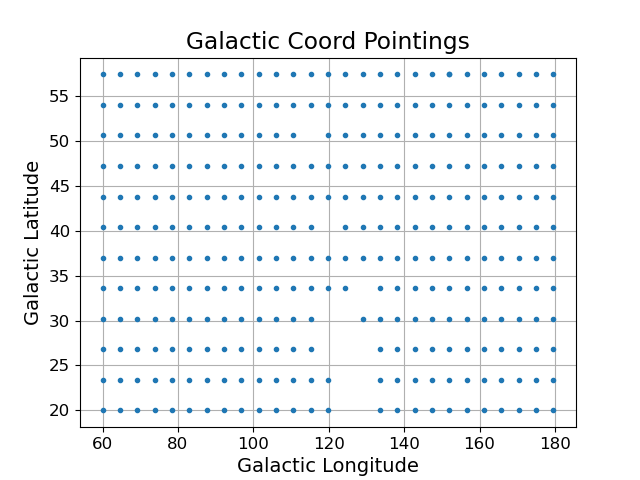

In [12]:
fig,ax = plt.subplots(1,1)
ax.plot(l, b, '.')
ax.set_xlabel('Galactic Longitude'), ax.set_ylabel('Galactic Latitude')
ax.set_title('Galactic Coord Pointings')
plt.grid(True)
plt.show()

#### Spectra Line & Functions

In [13]:
'''Building functions that automate the data collection and places them
   into the respective (l, b) on the above plot.
   
   Our actual galactic lon, lat data is stored in the following variables:
   • l : galactic longitude
   • b : galactic latitude 
   • jd: Julian dates associated with collected data pointings, might need
   '''


'Building functions that automate the data collection and places them\n   into the respective (l, b) on the above plot.\n   \n   Our actual galactic lon, lat data is stored in the following variables:\n   • l : galactic longitude\n   • b : galactic latitude \n   • jd: Julian dates associated with collected data pointings, might need\n   '

In [14]:
def shift(data):
    return np.fft.fftshift(data)

def gain(s_cal, s_cold):
    '''
    GET CALIBRATION DATA
    
    Params
    ------
    s_cal:  calibrated data, this is the data with noise diode turned on.
    s_cold: non-calibrated data, Leuschner pointed at arb. point.
    
    Output
    ------
    Gain calculated for Leuschner, we mult. all power spectra by this value.
    
    '''
    # T_cal  = 30 # K
    T_cal = 50 # K, this value is given in lab 2
    T_cold = 2.73 # K
    
    difference = s_cal - s_cold
    G = ((T_cal - T_cold) / (np.sum(difference))) * np.sum(s_cold)
    return G

In [15]:
def T_power(line, G):
    '''This function calculates the intensity of the power spectrum
       given the spectrum and gain value.
       
       Params
       --------
       line: the spectrum we will multiply by the gain.
       G   : the gain of Leuschner 
       
       Output
       --------
       power: the final calibrated intensity of the object in
              units of temperature.
       '''
    intensity = line * G
    return intensity
    

In [16]:
'''This code just sums all the spectra within the the pol0, pol1 data arrays
   can use sum function instead to effectively do the same thing.'''
# # Initialize accumulators
# # Assuming you can get the shape from the first file
# initial_file = np.load(files[0])
# data = np.zeros_like(initial_file['data0'])
# data_pol = np.zeros_like(initial_file['data1'])

# # Process each file
# for file_path in files:
#     npz_file = np.load(file_path)
#     for key in sorted(npz_file.keys()):
#         if 'data0' in key:
#             data += npz_file[key]
#         elif 'data1' in key:
#             data_pol += npz_file[key]

# # Now 'data' and 'data_pol' contain the sum from all files


'This code just sums all the spectra within the the pol0, pol1 data arrays\n   can use sum function instead to effectively do the same thing.'

In [17]:
# def data(hdu):
#     """
#     Function calculates the avg. power spectrum from the N samples
#     collected. The purpose is the reduce the noise in the power spectra.
    
#     Params:
#     -------
#     • hdu: data we attempt to avg. the power for.
#     • N  : number of integrated samples collected.
    
#     Output:
#     -------
#     • average: averaged power spectrum over N samples
#     """
#     N = len(hdu)
#     nu_samp = 3.2e6 # Hz, this was taken from our data collection script
    
#     M = 1 # counting variable
#     # data = 0
#     # data_pol = 0
#     while M <= N:
#         initial_file = np.load(files[M])
#         data = np.zeros_like(initial_file['data0'])
#         data_pol = np.zeros_like(initial_file['data1'])

#         # Process each file
#         for file_path in files:
#             npz_file = np.load(file_path)
#             for key in sorted(npz_file.keys()):
#                 if 'data0' in key:
#                     data += npz_file[key]
#                 elif 'data1' in key:
#                     data_pol += npz_file[key]
    
#     avg = data / N
#     avg_pol - data_pol / N
    
#     # avg between polarizations
#     sum_avg = (avg + avg_pol) / 2
#     spec = medfilt(sum_avg, kernal_size = 5)
    
#     return spec

In [18]:
'''
  Removing outliers from our data and smoothing overall
  
  Params: 
  -------
  • spec_test:  holds our reduced noise data for both polarizations. ----- this is what is returned
                and will be used to determine brightness temp, spec_test * gain
  • N:          length of the total amount of spectra collected, in this case 292 spectra.
  • avg0, avg1: contains data for pols 0, 1 respectively with reduced noise.

'''

spec_line = []
for i in range(len(pwr0)):
    N = len(pwr0)
    avg0 = pwr0[i] / N
    avg1 = pwr1[i] / N
    
    sum_avg = (avg0 + avg1) / 2
    spec = medfilt(sum_avg, kernel_size=5)
    spec_line.append(spec)

# spec_test = []  # List to store the spectrum for each array

# for i in range(len(pwr0)):
#     # Calculate the average of each array
#     avg0 = np.mean(pwr0[i])
#     avg1 = np.mean(pwr1[i])
    
#     # Calculate the average of the two averages
#     sum_avg = (avg0 + avg1) / 2
    
#     # Median filter the average and append to spec
#     filtered_spec = medfilt(sum_avg, kernel_size=5)  # Assuming a kernel size
#     spec_test.append(filtered_spec)

# Now spec contains the processed spectra for each array


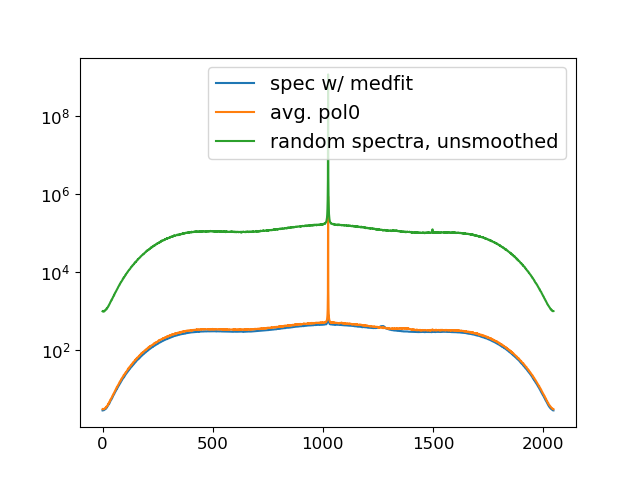

In [19]:
plt.figure()
plt.semilogy(shift(spec_line[0]), label='spec w/ medfit')
plt.semilogy(shift(avg0), label='avg. pol0')
plt.semilogy(shift(pwr0[291]), label='random spectra, unsmoothed')
plt.legend()
plt.show()

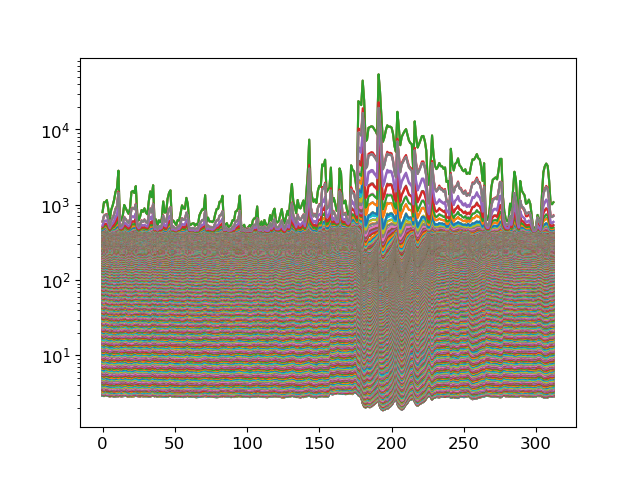

In [20]:
plt.figure()
plt.semilogy(spec_line)
plt.show()

In [21]:
print(len(spec_line[0]), len(spec_line))

2048 313


#### Calibration: Gain & Brightness Temp

In [22]:
cal_data0 = np.load('/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Noise_Spectra/NoiseSpec165_L111_B57.npz')['data0']
cold_data0 = np.load('/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042524/coldspec.npz')['data0']

cal_data1 = np.load('/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Noise_Spectra/NoiseSpec165_L111_B57.npz')['data1']
cold_data1 = np.load('/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042524/coldspec.npz')['data1']

In [23]:
'''
Determining Gain using both polarizations

• N: the length of our collected spectra data, in this case 292. This is used to reduce noise.


'''

_cal0  = cal_data0 / N
_cold0 = cold_data0 / N

_cal1 = cal_data1 / N
_cold1 = cold_data1 / N

avg_calspec = (_cal0 + _cal1) / 2
avg_coldspec = (_cold0 + _cold1) / 2

G = gain(avg_calspec, avg_coldspec)
print(f'Gain: {G}')

# spec_gain = spec_test[0] * G # for testing

Gain: 41.87120524585507


In [24]:
'''
Here we determine the brightness temperature of all spectra
by multiplying all spectra by the gain.

Params
------
• spec_line: contains all original reduced noise spectra
• calibrated_spec: contains all calibrated spectra taking into account the gain, i.e. brightness temp
'''

calibrated_spec = []
for i in range(len(pwr0)):
    spectra = spec_line[i] * G
    calibrated_spec.append(spectra) # brightness temp [K]
    
# '''Removing central spike'''
# corrected_spec = []
# for i in range(len(calibrated_spec)):
#     removing_cent_spike = calibrated_spec[i][980:1090] = 0
#     corrected_spec.append(removing_cent_spike)

In [55]:
for i in range(len(pwr0)): 
    pwr0[i] = np.fft.fftshift(pwr0[i])

for i in range(len(pwr1)):
    pwr1[i] = np.fft.fftshift(pwr1[i])

In [57]:
# import astropy.units as u

# '''determining the mean velocity value for each spectra'''
# mean_velocities = []
# for i in range(len(doppler_v)):
#     mean_v = np.mean(doppler_v[i])
#     mean_velocities.append(mean_v)
    
# '''converting the list of quantities to a numpy array...'''
# mean_velocities_values = np.array([v.value for v in mean_velocities])

In [58]:
def flip_divide(spectra):
    switch_set = spectra[0:1024] 
    switched = np.flip(switch_set)
    flatter = spectra[1024:2048]/switched
    chunked = flatter[5:600]
    return flatter, chunked, switched

#### Slicing Spectra for analysis
##### Paramters:

chunked0: contains sliced spectra, we multiply this by the gain to determine brightness temp.

In [149]:
divided0 = [] 
chunked0 = []
freqs_chunked0 = []
for i in range(len(pwr0)):
    '''Slicing the frequency axis on Polarization 0, i.e. removing the central spike
       Params:
       --------
       • Brightness spectra (T-line): Gain * flatter or chunked'''
    spectra = pwr0[i]
    switch_set = spectra[0:1024] 
    switched = np.flip(switch_set)
    flatter = spectra[1024:2048]/switched
    chunked = flatter[5:600]
    freq_divided = freqs[1024:2048]
    freq_chunked_axis = freq_divided[5:600]
    divided0.append(flatter)
    chunked0.append(chunked)
    freqs_chunked0.append(freq_chunked_axis)
    

In [94]:
ind = []
freq_peak = []
freq_divided = freqs[1024:2048]
freq_chunked = freq_divided[5:600]

for i in range(len(pwr0)):
    '''determining peak freq. values at which velocitiy is maximum for pol.0'''
    if 0 < i < 180 & 223 < i < 312:
        index = np.nanargmax(chunked0[i])
        ind.append(index)
        freq_peak.append(freq_chunked[index])
    else: 
        special_chunk = chunked0[i][200:450]
        freq_special = freq_chunked[200:450]
        index_special = np.nanargmax(special_chunk)
        ind.append(index_special)
        freq_peak.append(freq_special[index_special])     

In [61]:
len(freq_arr)

313

#### Projected Velocities & Brightness Temp

In [118]:
'''Determining the LSR Doppler Velocities'''
velocities = []  

for i in range(len(freq_arr)):
    RA = coordinates[i][3]
    DEC = coordinates[i][4]
    jd_i = jd[i]

    # Get projected velocity from the doppler function
    target_vel = ugradio.doppler.get_projected_velocity(ra=RA, dec=DEC, jd=jd_i)

    # Append the numeric value of the velocity, stripping the unit
    velocities.append(target_vel.value)

# Convert the list of velocities to a numpy array
velocities_array = np.array(velocities)

In [117]:
'''Determining maxima velocity values'''
c = 299792458 # m/s

velocity_peak = []
v_uncorrected = []
velocity_reversed = []
freqs_dopp = []
velocity_peak_kms = []

for i in range(len(freq_arr)):
    LSR_target_vel = velocities_array[i]
    nu = 1420
    delta_nu = freq_arr[i] - nu
    v = -(delta_nu / nu) * c
    dopp_v = v - LSR_target_vel
    freqs_corrected = ((c+(LSR_target_vel))/c)*freq_arr[i]
    freqs_dopp.append(freqs_corrected)
    v_uncorrected.append(v)
    velocity_peak.append(dopp_v)
    velocity_peak_kms.append(dopp_v/1000)   

In [249]:
brightness_temp = []
for i in range(len(chunked0)):
    b_temp = chunked0[i]* G
    # mean_brightness = (b_temp[i])
    brightness_temp.append(b_temp)
# brightness_temp
len(brightness_temp)

313

In [251]:
from scipy.signal import find_peaks

In [252]:
# getting the peaks 
# NOTE: this will work the same once we get temperature
# in reality we will be passing calibrated T-line spectra through this
temp_peaks = []
freq_divided = freqs[1024:2048]
freq_chunked = freq_divided[5:600]

for i in range(len(brightness_temp)):
    if 0 < i < 180 & 223 < i < 312:
        peaks_indices, _ = find_peaks(brightness_temp[i]) # get indices of the peaks 
        peak_values_pre = [] # make empty array for storing peak values in nested loop
        for j in range(len(peaks_indices)):
            indiv_peaks = brightness_temp[i][peaks_indices[j]] # grab peak value at index of the individual spectra
            peak_values_pre.append(indiv_peaks) # append the peak value to a list of peak values for THAT spectra
        peak_max = max(peak_values_pre) # take the max of the peak values array, THAT'S the MAIN HI peak for that spectra
        temp_peaks.append(peak_max)
    else: 
        brightness_again = brightness_temp[i][200:450]
        peaks_indices_special, _ = find_peaks(brightness_again) # get indices of the peaks 
        peak_values_pre_special = [] # make empty array for storing peak values in nested loop
        for j in range(len(peaks_indices_special)):
            indiv_peaks = brightness_again[peaks_indices_special[j]] # grab peak value at index of the individual spectra
            peak_values_pre_special.append(indiv_peaks) # append the peak value to a list of peak values for THAT spectra
        peak_max_special = max(peak_values_pre_special) # take the max of the peak values array, THAT'S the MAIN HI peak for that spectra
        temp_peaks.append(peak_max_special)

In [245]:
'''Determining mean frequencies at which doppler velocity peak occurs for each spec'''
mean_freq_dopp = []
for i in range(len(freqs_dopp)):
    mean_freq = np.mean(freqs_dopp[i])
    mean_freq_dopp.append(mean_freq)


In [65]:
# '''Determining the mean values for each velocity peak...'''
# mean_velocity_peaks = []
# for i in range(len(velocity_peak)):
#     mean_vel = np.mean(velocity_peak[i]) / 1000 # km/s
#     mean_velocity_peaks.append(mean_vel)
# # mean_velocities_values
# freqs_dopp[0][0], freqs_corrected[0]

In [246]:
neg_velocities = []
pos_velocities = []

for i in range(len(velocity_peak)):
    if velocity_peak[i] < 0: 
        neg_velocities.append(velocity_peak[i])
    else: 
        pos_velocities.append(velocity_peak[i])
len(pos_velocities), len(neg_velocities)

(0, 313)

#### Building Official Map

In [67]:
# plt.figure()
# plt.plot(mean_velocities_values, '.')
# # plt.plot(mean_velocity_peaks)
# plt.show()

In [74]:
# print(f'min, max galactic longitude: {min(l), max(l)}')
# print(f'min, max galactic latitude:  {min(b), max(b)}')

print(f'min, max galactic longitude: {min(ra), max(ra)}')
print(f'min, max galactic latitude:  {min(dec), max(dec)}')

min, max galactic longitude: ([69.00670953613457], [350.2781981661482])
min, max galactic latitude:  ([32.44704573697857], [85.31843807182514])


In [75]:
# glon = np.linspace(60, 180, 30)
# glat = np.linspace(20, 60, 14)
L_array = np.arange(60, 180, 4)
B_array = np.arange(20, 60, 3)

In [76]:
ll, bb = np.meshgrid(L_array, B_array)
print('row: ', len(bb[:,0]))
print('col: ', len(bb[0,:]))

row:  14
col:  30


In [109]:
'''Making an empty matrix with the same row/cols as above.
   This will hold the information for the data collected 
   from our observations.'''
matrix_practice = np.zeros((50, 50))

In [110]:
'''
• lb_val : holds our galactic coordinates
• indexes: where the index is located in our meshgrid array
'''
lb_val  = []
indexes = []

for i in range(len(ll[:,0])):
    for j in range(len(bb[0,:])):
        
        #HOLDING THE ROW INDEX
        row = i
        #HOLDS THE COLUMN INDEX
        column = j
        
        #HOLDS THE INDEX IN A LIST
        index = [i,j]
        
        #APPENDING THE VALUE FOR LL AND BB INTO THE [L,B] GALACTIC COORDINATES
        lb_val.append([ll[i,j], bb[i,j]])
        indexes.append(index)

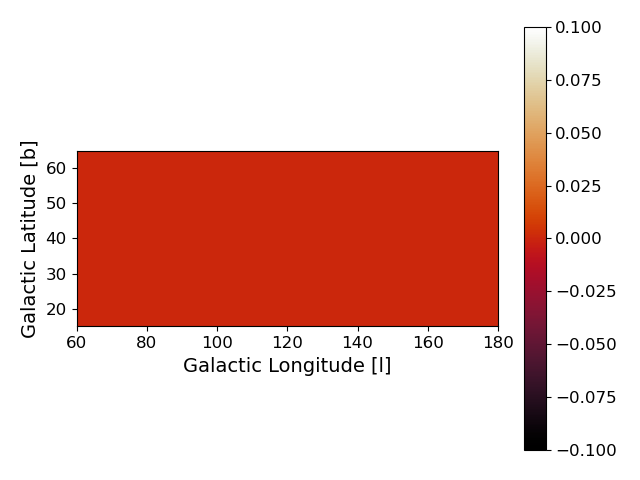

In [111]:
plt.figure()
plt.imshow(matrix_practice, 
           interpolation='nearest',
           origin= 'lower',
           extent=[60, 180, 15, 65],
           cmap = cmr.sunburst
          )
plt.xlabel('Galactic Longitude [l]')
plt.ylabel('Galactic Latitude [b]')
plt.colorbar()
plt.tight_layout()
plt.show()

In [254]:
'''Filling empty matrix with peak velocity values indexed by each row, column'''

matrix = np.empty((14, 30, 1))
matrix[:] = np.nan

matrix_contour = np.empty((14,30))
matrix_contour[:] = np.nan

matrix_brightness = np.empty((14, 30, 1))
matrix_brightness[:] = np.nan

l_tolerance = 5.6
b_tolerance = 2.7

for i in range(len(velocity_peak)):
    
    l = float(galactic[i][0])
    b = float(galactic[i][1])

    for m in range(len(lb_val)):
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        if np.isclose(l, lb_val[m][0], atol=l_tolerance) and np.isclose(b, lb_val[m][1], atol=b_tolerance):
            row_index = indexes[m][0]
            column_index = indexes[m][1]
            
            # Obtaining corresponding velocities
            dop = velocity_peak_kms[i]
            
            # Obtaining correspinding brightness temperatures
            temp = temp_peaks[i]
            matrix_brightness[row_index, column_index,0] = temp

            #if dop > 20000: 
            matrix[row_index, column_index,0] = dop
            matrix_contour[row_index, column_index] = dop
            #else: 
             #   matrix[row_index, column_index, 0] = np.nan

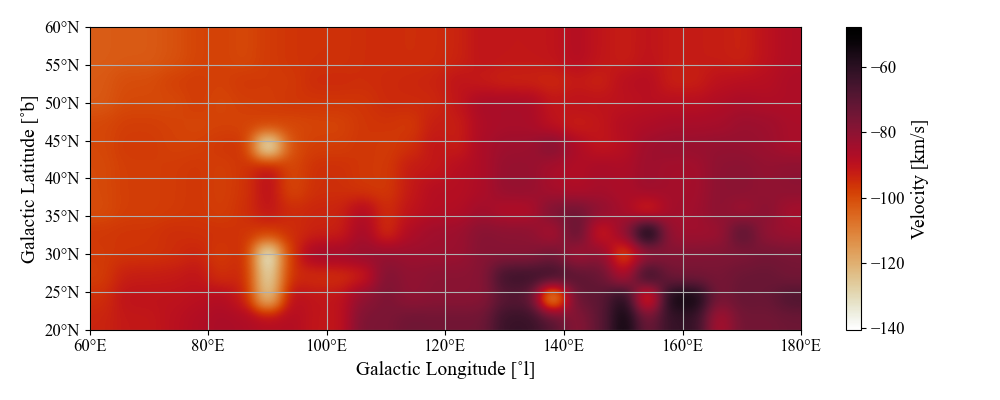

In [271]:
def add_degree_N(x, pos):
    return f"{int(x)}°N"

def add_degree_E(x, pos):
    return f"{int(x)}°E"

fig, ax = plt.subplots(1,1,figsize=(10,4))
im = ax.imshow(matrix, 
               interpolation='gaussian',
               extent=[60, 180, 20, 60], 
               cmap=cmr.sunburst_r,
               aspect='auto',
               origin='lower',
               vmin=np.amin(velocity_peak_kms), 
               vmax=np.amax(velocity_peak_kms))


cbar = fig.colorbar(im, ax=ax, label='Velocity [km/s]')
ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
ax.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
ax.set_xlabel('Galactic Longitude [˚l]')
ax.set_ylabel('Galactic Latitude [˚b]')
plt.tight_layout()
plt.grid(True)
plt.show()


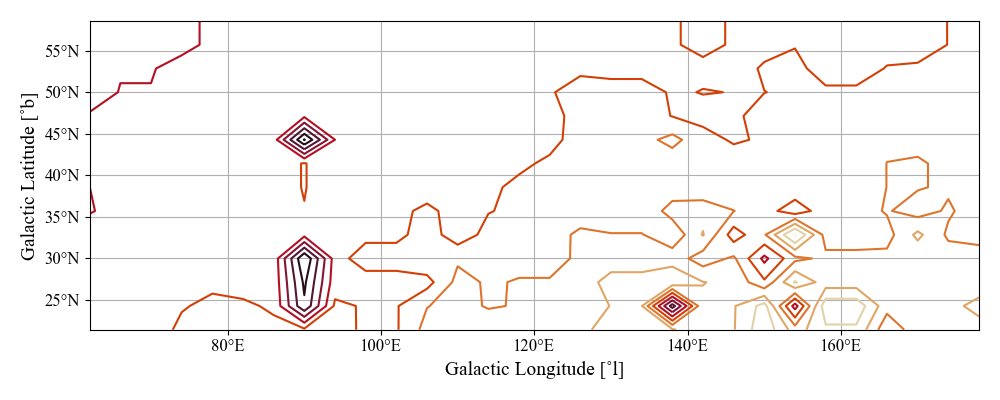

In [272]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
im = ax.contour(matrix_contour, 
               levels = np.arange(-300, 300, 10),
               extent=[60, 180, 20, 60], 
               cmap=cmr.sunburst,
               origin='lower',
               vmin=np.amin(velocity_peak_kms), 
               vmax=np.amax(velocity_peak_kms))

# cbar = fig.colorbar(im, ax=ax, label='Velocity [km/s]')
ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
ax.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
ax.set_xlabel('Galactic Longitude [˚l]')
ax.set_ylabel('Galactic Latitude [˚b]')
plt.tight_layout()
plt.grid(True)
plt.show()

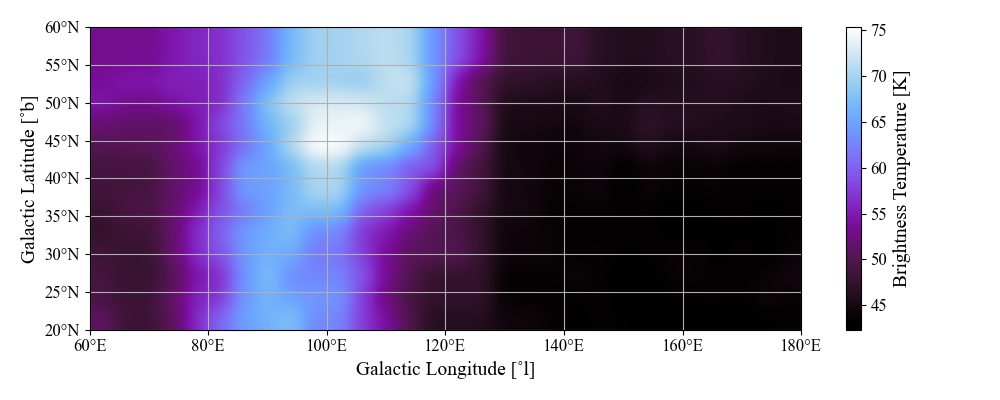

In [273]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
im = ax.imshow(matrix_brightness, 
               interpolation='gaussian',
               extent=[60, 180, 20, 60], 
               cmap=cmr.voltage,
               aspect='auto',
               origin='lower',
               vmin=np.amin(temp_peaks), 
               vmax=np.amax(temp_peaks))


cbar = fig.colorbar(im, ax=ax, label='Brightness Temperature [K]')
ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
ax.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
ax.set_xlabel('Galactic Longitude [˚l]')
ax.set_ylabel('Galactic Latitude [˚b]')
plt.tight_layout()
plt.grid(True)
plt.show()


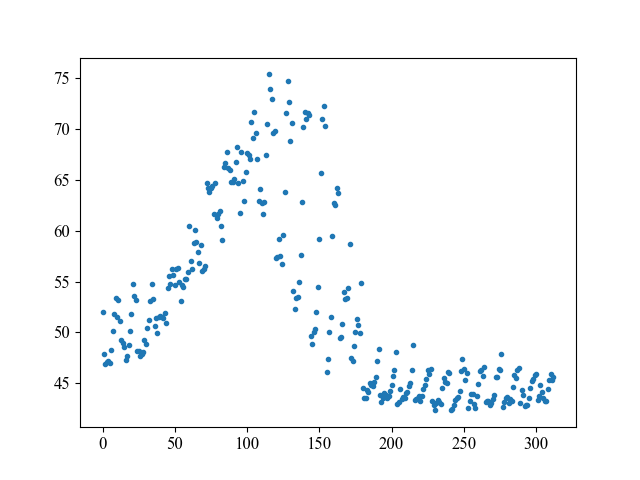

In [275]:
plt.figure()
plt.plot(temp_peaks, '.')
plt.show()